In [1]:
import jax.numpy as jnp
import jax
from jax import random
import matplotlib.pyplot as plt
from jax import lax

Part 1

In [5]:
# Data
σ = 0.04
r = 0.01
K = 35

# Design choice
dt = 0.01
m = 100

def simulate1():
  

  def step(S):
    dZ = jax.random.normal(key=random.PRNGKey(t), shape=(1,jnp.size(S)))[0] * jnp.sqrt(dt)
    dS = r * S  * dt + σ  * S  * dZ
    S = S + dS
    return S

  S0 = jnp.ones(20000)
  S = S0
  S_list = []

  for t in range(m):
    S = step(S)
    S_list.append(S)

  S_array = jnp.stack(S_list)
  return S_array

In [6]:
result1 = simulate1()

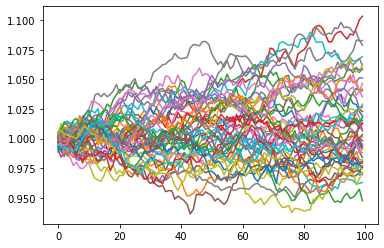

In [8]:
plt.plot(result1[:, :50]);

Part 2

In [11]:
import jax.numpy as jnp
import jax
from jax import random
import matplotlib.pyplot as plt
from jax import lax

# Data
σ = 0.04
r = 0.01
K = 35

# Design choice
dt = 0.01

@jax.jit
def simulate2():
  S0 = jnp.ones(20000)
  S = S0
  m = jnp.arange(1,101)
  def step_S(S, m):
    key = random.PRNGKey(m)
    dZ = jax.random.normal(key, shape=(S.shape)) * jnp.sqrt(dt)
    dS = r*S*dt + σ * S * dZ
    S = S + dS
    return S, S
  final, S100 = jax.lax.scan(step_S, S, m)
  S_array = jnp.stack(S100)
  return S_array



In [13]:
result2 = simulate2()

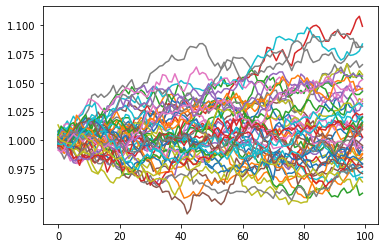

In [14]:
plt.plot(result2[:, :50]);

Part 3

In [3]:

Spot = 36   # stock price
σ = 0.2     # stock volatility
K = 40      # strike price
r = 0.06    # risk free rate
n = 100000  # Number of simualted paths
m = 50      # number of exercise dates
T = 1       # maturity
order = 12   # Polynmial order
Δt = T / m  # interval between two exercise dates


# Construct polynomial features of order up to k using the
# recursive formulation
def chebyshev_basis(x, k):
    B = [jnp.ones(len(x)), x]
    for n in range(2, k):
        Bn = 2 * x * B[n - 1] - B[n - 2]
        B.append(Bn)

    return jnp.column_stack(B)


# scales x to be in the interval(-1, 1)
def scale(x):
    xmin = x.min()
    xmax = x.max()
    a = 2 / (xmax - xmin)
    b = 1 - a * xmax
    return a * x + b


# simulates one step of the stock price evolution
def payoff_put(S):
    return jnp.maximum(K - S, 0.)


# LSMC algorithm
def compute_price():  
    random.PRNGKey(0)
    S0 = Spot * jnp.ones(n)
    S = [S0]
    
    def step(S):
      dB = jnp.sqrt(Δt) * jax.random.normal(key=random.PRNGKey(t), shape=(1,jnp.size(S)))[0]
      S_tp1 = S + r * S * Δt + σ * S * dB
      return S_tp1

    for t in range(m):
        S_tp1 = step(S[t])
        S.append(S_tp1)

    discount = jnp.exp(-r * Δt)

    # Very last date
    value_if_exercise = payoff_put(S[-1])
    discounted_future_cashflows = value_if_exercise * discount

    # Proceed recursively
    for i in range(m - 1):
        X = chebyshev_basis(scale(S[-2 - i]), order)
        Y = discounted_future_cashflows

        Θ = jnp.linalg.solve(X.T @ X, X.T @ Y)
        value_if_wait = X @ Θ
        value_if_exercise = payoff_put(S[-2 - i])
        exercise = value_if_exercise >= value_if_wait
        discounted_future_cashflows = discount * jnp.where(
            exercise,
            value_if_exercise,
            discounted_future_cashflows)

    return discounted_future_cashflows.mean()


print(compute_price())
# test = compute_price(order, Spot, σ, K, r)


4.474934
